## Setup

In [1]:
##### Setup #####
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt

## Load the data
download the zip file with terminal
* curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
* unzip -q kagglecatsanddogs_3367a.zip
* ls

## Filter out corrupted images

In [21]:
##### Filter out corrupted images #####


num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


## Generate a dataset

In [3]:
##### Generate a dataset #####
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split = 0.2,
    subset = "training",
    seed = 1337,
    image_size = image_size,
    batch_size = batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split = 0.2,
    subset = "validation",
    seed = 1337,
    image_size = image_size,
    batch_size = batch_size
)

Found 23422 files belonging to 2 classes.
Using 18738 files for training.
Found 23422 files belonging to 2 classes.
Using 4684 files for validation.


## Visualize the data

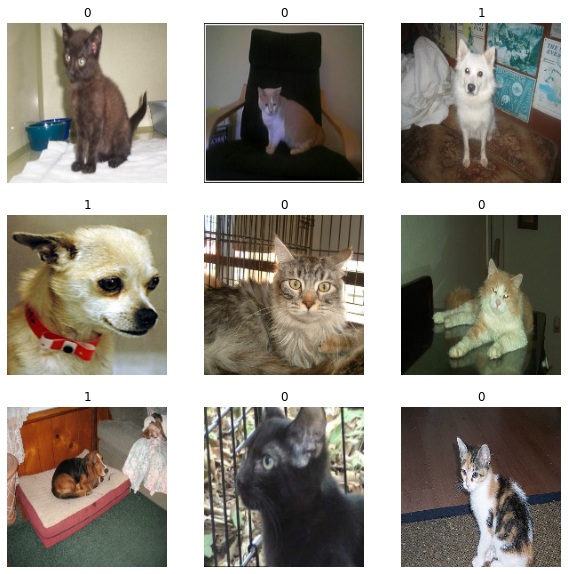

In [4]:
##### Visualize the data #####


plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Using image data augmentation

In [5]:
##### Using image data augmentation #####
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1)
    ]
)

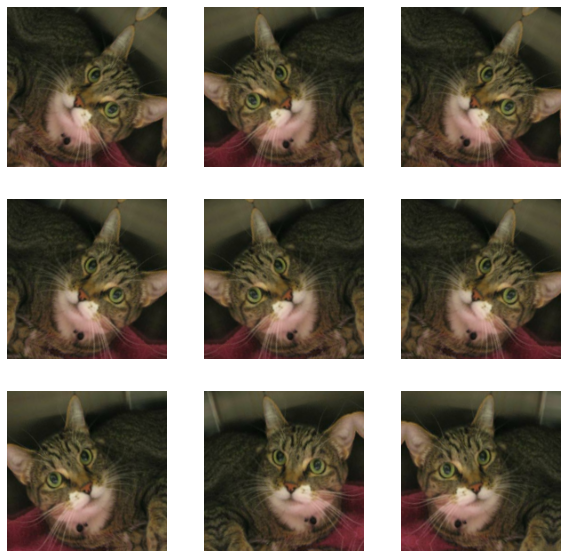

In [6]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Standardizing the data
1. size (all same)
2. RGB (0~1)

## Configure the dataset for performance

In [7]:
##### Configure the dataset for performance #####
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

## Build a model

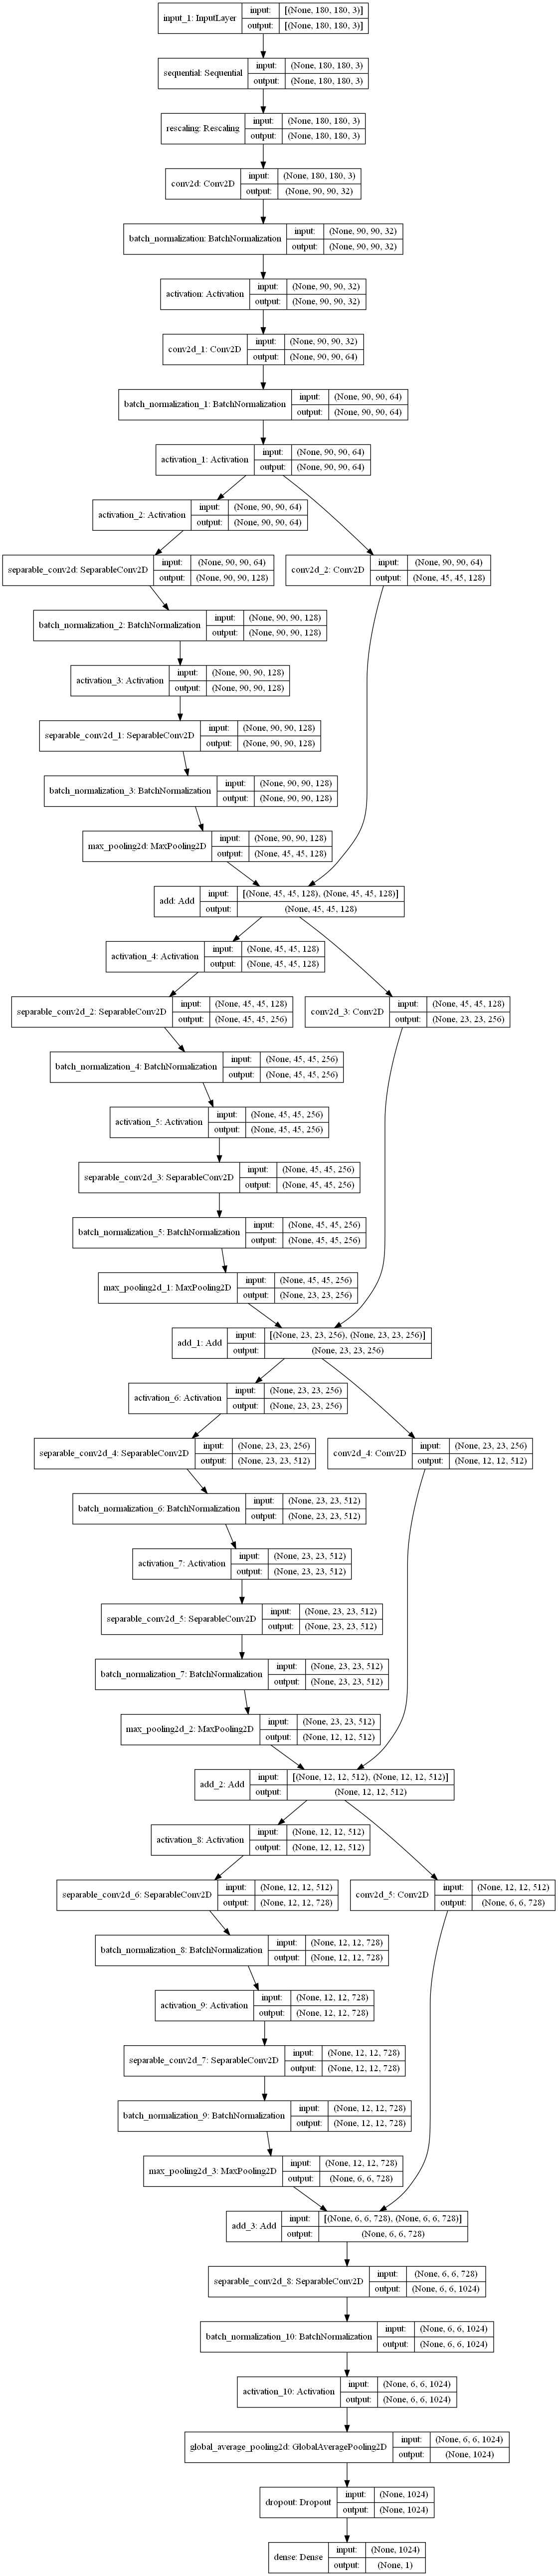

In [8]:
##### Build a model #####
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

## Train the model

In [12]:
epochs = 10
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics = ["accuracy"]
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds
)

Epoch 1/10
586/586 [==============================] - 142s 240ms/step - loss: 0.3359 - accuracy: 0.8549 - val_loss: 0.2826 - val_accuracy: 0.8802
Epoch 2/10
586/586 [==============================] - 141s 241ms/step - loss: 0.2776 - accuracy: 0.8833 - val_loss: 0.2534 - val_accuracy: 0.8982
Epoch 3/10
586/586 [==============================] - 143s 244ms/step - loss: 0.2440 - accuracy: 0.8984 - val_loss: 0.4831 - val_accuracy: 0.8185
Epoch 4/10
586/586 [==============================] - 141s 240ms/step - loss: 0.2164 - accuracy: 0.9084 - val_loss: 0.5312 - val_accuracy: 0.8187
Epoch 5/10
586/586 [==============================] - 141s 241ms/step - loss: 0.1936 - accuracy: 0.9187 - val_loss: 0.1816 - val_accuracy: 0.9242
Epoch 6/10
586/586 [==============================] - 142s 243ms/step - loss: 0.1837 - accuracy: 0.9235 - val_loss: 0.1622 - val_accuracy: 0.9362
Epoch 7/10
586/586 [==============================] - 140s 238ms/step - loss: 0.1675 - accuracy: 0.9333 - val_loss: 0.1781 -

In [23]:
img = keras.preprocessing.image.load_img(
    "PetImages/Dog/667.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

This image is 6.13 percent cat and 93.87 percent dog.
